## Contraceptive Dataset Cleaning
This notebook reads in the contraceptive dataset from the UCI Machine Learning site.

In [6]:
%matplotlib inline

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [7]:
# Read in csv file and initialize a pandas dataframe
X_and_Y = pd.read_csv('contraceptive.data', header=None)

In [8]:
# I chose to drop the rows for women who used long-term contraceptives, focusing instead on women who 
# either use short-term birth control or do not use birth-control.
X_and_Y = X_and_Y[X_and_Y[9] != 3]

In [9]:
# Shuffle the data.
X_and_Y = X_and_Y.reindex(np.random.permutation(X_and_Y.index))
X_and_Y.reset_index(drop=True, inplace=True)
# Last column is labels
# Split data into X and Y matrices
X = X_and_Y.loc[:,:8] # Features
Y = X_and_Y.loc[:,9]

In [10]:
# Transform Y labels into 1 for long-term and 0 for short-term
Y = Y.replace(2, 0)

## Partition Function

In [11]:
#    Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (First x% of all data points)
#    (b) Test set                       (Last (100-x)% of all data points)
def partition(x):
    split = len(Y)* x
    data_holder = list()
    data_holder.append(X.loc[:split,:])
    data_holder.append(X.loc[split:,:])
    data_holder.append(Y.loc[:split])
    data_holder.append(Y.loc[split:])
    return data_holder

## Heatmap Function

In [12]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

## Performing SVM with Partition 1

#### Partition 1

In [13]:
# Call partition function for the first split where 20% of data is testing data and 80% is training data
temp = partition(0.8)
X_train_val = temp[0]
X_test  = temp[1] 
Y_train_val = temp[2]
Y_test = temp[3]

In [14]:
# Perform grid search with 3-fold cross-validation.
# Draw heatmaps for result of grid search and find 
# best C for validation set.
classifier = svm.SVC(kernel='linear')
C_list = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1] # Different C to try.
parameters = {'C': C_list, 'kernel': ['linear']}
g_search = GridSearchCV(classifier, parameters, cv=3, return_train_score=True)
g_search.fit(X_train_val, Y_train_val)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

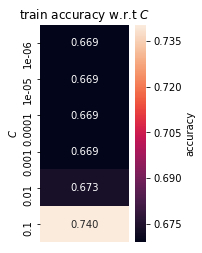

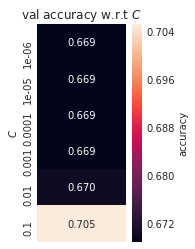

In [15]:
train_acc = g_search.cv_results_['mean_train_score'].reshape(len(C_list), 1)
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = g_search.cv_results_['mean_test_score'].reshape(len(C_list),1)
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [16]:
# From the heatmap results, the best C value appears to be 0.1. We will use this parameter to train our SVM classifier
svm_clf = svm.SVC(kernel='linear',C=0.1)
svm_clf.fit(X_train_val, Y_train_val)
test_acc = np.mean( svm_clf.predict(X_test) == Y_test )
print(test_acc)

0.671875


## Using Decision Tree on Partition 1

In [17]:
D = [1, 2, 3, 4, 5, 6]    # Set for maximum depth options for the tree classifier
clf = tree.DecisionTreeClassifier(criterion='entropy') # Using sklearn decision tree classifer 
params ={'max_depth':D}
clf = GridSearchCV(clf, params, cv=5, return_train_score=True) # Use grid search with maximum depth options and 5-fold cross validation
clf = clf.fit(X_train_val, Y_train_val) # Fit the classifer

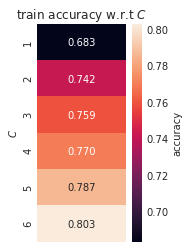

In [18]:
train_acc = clf.cv_results_['mean_train_score'].reshape(len(D), 1)
draw_heatmap_linear(train_acc, 'train accuracy', D)

In [19]:
# Train new classifier with optimal D
new_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
new_clf = new_clf.fit(X_train_val, Y_train_val) 

In [20]:
test_acc = np.mean( new_clf.predict(X_test) == Y_test )
print(test_acc)

0.6875


## Using Random Forest Classifier with Partition 1

In [21]:
D = [1, 2, 3, 4, 5, 6]  # Set for maximum depth options for the tree classifier
clf = RandomForestClassifier(criterion='entropy') # Using sklearn decision tree classifer 
params ={'max_depth':D}
clf = GridSearchCV(clf, params, cv=5, return_train_score=True) # Use grid search with maximum depth options and 5-fold cross validation
clf = clf.fit(X_train_val, Y_train_val) # Fit the classifer

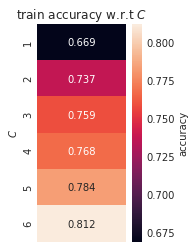

In [22]:
train_acc = clf.cv_results_['mean_train_score'].reshape(len(D), 1)
draw_heatmap_linear(train_acc, 'train accuracy', D)

In [23]:
# Train new classifier with optimal D
new_clf = RandomForestClassifier(criterion='entropy', max_depth=5)
new_clf = new_clf.fit(X_train_val, Y_train_val)
test_acc = np.mean( new_clf.predict(X_test) == Y_test )
print(test_acc)

0.697916666667


#### Partition 2

In [24]:
# Call partition function for the first split where 50% of data is testing data and 50% is training data
temp = partition(0.5)
X_train_val = temp[0]
X_test  = temp[1] 
Y_train_val = temp[2]
Y_test = temp[3]

## Using SVM with 2nd partition

In [25]:
# Perform grid search with 3-fold cross-validation.
# Draw heatmaps for result of grid search and find 
# best C for validation set.
classifier = svm.SVC(kernel='linear')
C_list = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1] # Different C to try.
parameters = {'C': C_list, 'kernel': ['linear']}
g_search = GridSearchCV(classifier, parameters, cv=3, return_train_score=True)
g_search.fit(X_train_val, Y_train_val)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

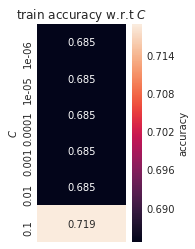

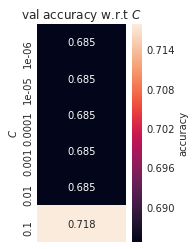

In [26]:
train_acc = g_search.cv_results_['mean_train_score'].reshape(len(C_list), 1)
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = g_search.cv_results_['mean_test_score'].reshape(len(C_list),1)
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [27]:
# From the heatmap results, the best C value appears to be 0.1. We will use this parameter to train our SVM classifier
svm_clf = svm.SVC(kernel='linear',C=0.1)
svm_clf.fit(X_train_val, Y_train_val)
test_acc = np.mean( svm_clf.predict(X_test) == Y_test )
print(test_acc)

0.677754677755


## Using Decision Tree with 2nd partition

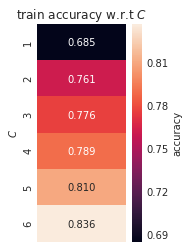

In [28]:
D = [1, 2, 3, 4, 5, 6]    # Set for maximum depth options for the tree classifier
clf = tree.DecisionTreeClassifier(criterion='entropy') # Using sklearn decision tree classifer 
params ={'max_depth':D}
clf = GridSearchCV(clf, params, cv=5, return_train_score=True) # Use grid search with maximum depth options and 5-fold cross validation
clf = clf.fit(X_train_val, Y_train_val) # Fit the classifer

train_acc = clf.cv_results_['mean_train_score'].reshape(len(D), 1)
draw_heatmap_linear(train_acc, 'train accuracy', D)

In [29]:
# Train new classifier with optimal D
new_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
new_clf = new_clf.fit(X_train_val, Y_train_val) 

test_acc = np.mean( new_clf.predict(X_test) == Y_test )
print(test_acc)

0.677754677755


## Random forest Classifier with 2nd partition

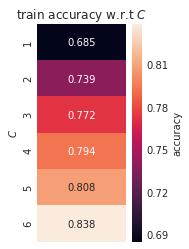

In [30]:
D = [1, 2, 3, 4, 5, 6]  # Set for maximum depth options for the tree classifier
clf = RandomForestClassifier(criterion='entropy') # Using sklearn decision tree classifer 
params ={'max_depth':D}
clf = GridSearchCV(clf, params, cv=5, return_train_score=True) # Use grid search with maximum depth options and 5-fold cross validation
clf = clf.fit(X_train_val, Y_train_val) # Fit the classifer

train_acc = clf.cv_results_['mean_train_score'].reshape(len(D), 1)
draw_heatmap_linear(train_acc, 'train accuracy', D)

In [31]:
# Train new classifier with optimal D
new_clf = RandomForestClassifier(criterion='entropy', max_depth=5)
new_clf = new_clf.fit(X_train_val, Y_train_val)
test_acc = np.mean( new_clf.predict(X_test) == Y_test )
print(test_acc)

0.719334719335


#### Partition 3

In [32]:
# Call partition function for the first split where 20% of data is testing data and 80% is training data
temp = partition(0.2)
X_train_val = temp[0]
X_test  = temp[1] 
Y_train_val = temp[2]
Y_test = temp[3]

## SVM with 3rd partition

In [33]:
# Perform grid search with 3-fold cross-validation.
# Draw heatmaps for result of grid search and find 
# best C for validation set.
classifier = svm.SVC(kernel='linear')
C_list = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1] # Different C to try.
parameters = {'C': C_list, 'kernel': ['linear']}
g_search = GridSearchCV(classifier, parameters, cv=3, return_train_score=True)
g_search.fit(X_train_val, Y_train_val)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

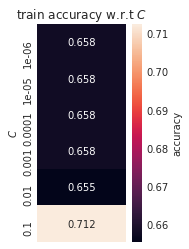

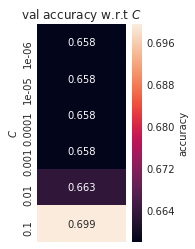

In [34]:
train_acc = g_search.cv_results_['mean_train_score'].reshape(len(C_list), 1)
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = g_search.cv_results_['mean_test_score'].reshape(len(C_list),1)
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [35]:
# From the heatmap results, the best C value appears to be 0.1. We will use this parameter to train our SVM classifier
svm_clf = svm.SVC(kernel='linear',C=0.1)
svm_clf.fit(X_train_val, Y_train_val)
test_acc = np.mean( svm_clf.predict(X_test) == Y_test )
print(test_acc)

0.687906371912


## Decision Tree with 3rd partition

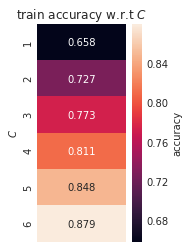

In [36]:
D = [1, 2, 3, 4, 5, 6]    # Set for maximum depth options for the tree classifier
clf = tree.DecisionTreeClassifier(criterion='entropy') # Using sklearn decision tree classifer 
params ={'max_depth':D}
clf = GridSearchCV(clf, params, cv=5, return_train_score=True) # Use grid search with maximum depth options and 5-fold cross validation
clf = clf.fit(X_train_val, Y_train_val) # Fit the classifer

train_acc = clf.cv_results_['mean_train_score'].reshape(len(D), 1)
draw_heatmap_linear(train_acc, 'train accuracy', D)

In [37]:
# Train new classifier with optimal D
new_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
new_clf = new_clf.fit(X_train_val, Y_train_val) 

test_acc = np.mean( new_clf.predict(X_test) == Y_test )
print(test_acc)

0.736020806242


## Random forest Classifier with 3rd partition

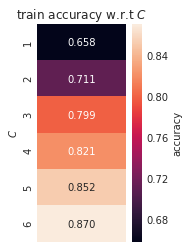

In [38]:
D = [1, 2, 3, 4, 5, 6]  # Set for maximum depth options for the tree classifier
clf = RandomForestClassifier(criterion='entropy') # Using sklearn decision tree classifer 
params ={'max_depth':D}
clf = GridSearchCV(clf, params, cv=5, return_train_score=True) # Use grid search with maximum depth options and 5-fold cross validation
clf = clf.fit(X_train_val, Y_train_val) # Fit the classifer

train_acc = clf.cv_results_['mean_train_score'].reshape(len(D), 1)
draw_heatmap_linear(train_acc, 'train accuracy', D)

In [39]:
# Train new classifier with optimal D
new_clf = RandomForestClassifier(criterion='entropy', max_depth=5)
new_clf = new_clf.fit(X_train_val, Y_train_val)
test_acc = np.mean( new_clf.predict(X_test) == Y_test )
print(test_acc)

0.729518855657
